In [1]:
# Imports
import numpy as np
import pandas as pd
from collections import defaultdict, deque

# Load main CSV
df = pd.read_csv(
    'full_all_data.csv',
    parse_dates=['Date'],
    dayfirst=True
)

/tmp/ipython-input-1893473036.py:7: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df = pd.read_csv(


In [2]:
# Create team → index mapping
all_teams = pd.unique(df[['HomeTeam', 'AwayTeam']].values.ravel())
all_teams = sorted(all_teams)
team_to_idx = {team: idx for idx, team in enumerate(all_teams)}
num_teams = len(all_teams)

def team_to_one_hot(team):
    vec = np.zeros(num_teams)
    vec[team_to_idx[team]] = 1
    return vec

# Convert teams to one-hot vectors
home_one_hots = np.vstack(df['HomeTeam'].apply(team_to_one_hot))
away_one_hots = np.vstack(df['AwayTeam'].apply(team_to_one_hot))

**Prepare all features**

In [3]:
# Feature - Last-X-wins
window_size = 5 # = X
team_last_wins = defaultdict(lambda: deque(maxlen=window_size))
df['last5_wins_H'] = 0
df['last5_wins_A'] = 0

for season, group in df.groupby('Season', sort=False):
#    team_last_wins.clear()
    for idx in group.index:
        home = df.at[idx, 'HomeTeam']
        away = df.at[idx, 'AwayTeam']
        ftr = df.at[idx, 'FTR']
        df.at[idx, 'last5_wins_H'] = sum(team_last_wins[home])
        df.at[idx, 'last5_wins_A'] = sum(team_last_wins[away])
        home_win = 1 if ftr == 'H' else 0
        away_win = 1 if ftr == 'A' else 0
        team_last_wins[home].append(home_win)
        team_last_wins[away].append(away_win)

In [4]:
# Feature - Head-to-Head

from collections import defaultdict


# Initialize empty columns for directional H2H
df['h2h_home_win_rate'] = 0.0
df['h2h_away_win_rate'] = 0.0
df['h2h_draw_rate'] = 0.0
df['h2h_total_matches'] = 0

# Initialize empty columns for symmetric H2H
df['h2h_sym_team1_win_rate'] = 0.0
df['h2h_sym_team2_win_rate'] = 0.0
df['h2h_sym_draw_rate'] = 0.0
df['h2h_sym_total_matches'] = 0

# Dictionaries to store history
directional_history = defaultdict(list)  # key = (home, away)
symmetric_history = defaultdict(list)    # key = tuple(sorted([team1, team2]))

for idx in df.index:
    home = df.at[idx, 'HomeTeam']
    away = df.at[idx, 'AwayTeam']
    ftr = df.at[idx, 'FTR']

    # --- Directional H2H ---
    dir_key = (home, away)
    dir_hist = directional_history[dir_key]
    dir_total = len(dir_hist)

    if dir_total > 0:
        home_wins = sum(1 for r in dir_hist if r == 'H')
        away_wins = sum(1 for r in dir_hist if r == 'A')
        draws = sum(1 for r in dir_hist if r == 'D')

        df.at[idx, 'h2h_home_win_rate'] = home_wins / dir_total
        df.at[idx, 'h2h_away_win_rate'] = away_wins / dir_total
        df.at[idx, 'h2h_draw_rate'] = draws / dir_total
        df.at[idx, 'h2h_total_matches'] = dir_total

    # --- Symmetric H2H ---
    sym_key = tuple(sorted([home, away]))
    sym_hist = symmetric_history[sym_key]
    sym_total = len(sym_hist)

    if sym_total > 0:
        # Determine which team is team1 and team2 in the sorted tuple
        team1, team2 = sym_key

        # Count wins for team1 and team2 according to match result and who was home
        if home == team1:
            team1_wins = sum(1 for r in sym_hist if r == 'H')
            team2_wins = sum(1 for r in sym_hist if r == 'A')
        else:
            # Home is team2, reverse win coding
            team1_wins = sum(1 for r in sym_hist if r == 'A')
            team2_wins = sum(1 for r in sym_hist if r == 'H')

        draws = sum(1 for r in sym_hist if r == 'D')

        df.at[idx, 'h2h_sym_team1_win_rate'] = team1_wins / sym_total
        df.at[idx, 'h2h_sym_team2_win_rate'] = team2_wins / sym_total
        df.at[idx, 'h2h_sym_draw_rate'] = draws / sym_total
        df.at[idx, 'h2h_sym_total_matches'] = sym_total

    # Append current match result to histories AFTER computing features
    directional_history[dir_key].append(ftr)
    symmetric_history[sym_key].append(ftr)

In [5]:
# Feature - Total goals scored and conceded in last X games

from collections import defaultdict, deque

window_size = 5 # = X

# Prepare columns for home team
df['home_goals_scored_home_lastX'] = 0
df['home_goals_conceded_home_lastX'] = 0
df['home_goals_scored_away_lastX'] = 0
df['home_goals_conceded_away_lastX'] = 0
df['home_goals_scored_total_lastX'] = 0
df['home_goals_conceded_total_lastX'] = 0

# Prepare columns for away team
df['away_goals_scored_home_lastX'] = 0
df['away_goals_conceded_home_lastX'] = 0
df['away_goals_scored_away_lastX'] = 0
df['away_goals_conceded_away_lastX'] = 0
df['away_goals_scored_total_lastX'] = 0
df['away_goals_conceded_total_lastX'] = 0

# Rolling windows for home team
home_goals_scored_home = defaultdict(lambda: deque(maxlen=window_size))
home_goals_conceded_home = defaultdict(lambda: deque(maxlen=window_size))
home_goals_scored_away = defaultdict(lambda: deque(maxlen=window_size))
home_goals_conceded_away = defaultdict(lambda: deque(maxlen=window_size))
home_goals_scored_total = defaultdict(lambda: deque(maxlen=window_size))
home_goals_conceded_total = defaultdict(lambda: deque(maxlen=window_size))

# Rolling windows for away team
away_goals_scored_home = defaultdict(lambda: deque(maxlen=window_size))
away_goals_conceded_home = defaultdict(lambda: deque(maxlen=window_size))
away_goals_scored_away = defaultdict(lambda: deque(maxlen=window_size))
away_goals_conceded_away = defaultdict(lambda: deque(maxlen=window_size))
away_goals_scored_total = defaultdict(lambda: deque(maxlen=window_size))
away_goals_conceded_total = defaultdict(lambda: deque(maxlen=window_size))

for idx in df.index:
    home = df.at[idx, 'HomeTeam']
    away = df.at[idx, 'AwayTeam']
    home_goals = df.at[idx, 'FTHG']
    away_goals = df.at[idx, 'FTAG']

    # Home team features before current match
    df.at[idx, 'home_goals_scored_home_lastX'] = sum(home_goals_scored_home[home])
    df.at[idx, 'home_goals_conceded_home_lastX'] = sum(home_goals_conceded_home[home])
    df.at[idx, 'home_goals_scored_away_lastX'] = sum(home_goals_scored_away[home])
    df.at[idx, 'home_goals_conceded_away_lastX'] = sum(home_goals_conceded_away[home])
    df.at[idx, 'home_goals_scored_total_lastX'] = sum(home_goals_scored_total[home])
    df.at[idx, 'home_goals_conceded_total_lastX'] = sum(home_goals_conceded_total[home])

    # Away team features before current match
    df.at[idx, 'away_goals_scored_home_lastX'] = sum(away_goals_scored_home[away])
    df.at[idx, 'away_goals_conceded_home_lastX'] = sum(away_goals_conceded_home[away])
    df.at[idx, 'away_goals_scored_away_lastX'] = sum(away_goals_scored_away[away])
    df.at[idx, 'away_goals_conceded_away_lastX'] = sum(away_goals_conceded_away[away])
    df.at[idx, 'away_goals_scored_total_lastX'] = sum(away_goals_scored_total[away])
    df.at[idx, 'away_goals_conceded_total_lastX'] = sum(away_goals_conceded_total[away])

    # Append current match results for home team
    home_goals_scored_home[home].append(home_goals)
    home_goals_conceded_home[home].append(away_goals)
    home_goals_scored_away[home].append(0)  # no away match here
    home_goals_conceded_away[home].append(0)
    home_goals_scored_total[home].append(home_goals)
    home_goals_conceded_total[home].append(away_goals)

    # Append current match results for away team
    away_goals_scored_home[away].append(0)  # no home match here
    away_goals_conceded_home[away].append(0)
    away_goals_scored_away[away].append(away_goals)
    away_goals_conceded_away[away].append(home_goals)
    away_goals_scored_total[away].append(away_goals)
    away_goals_conceded_total[away].append(home_goals)

In [6]:
# Feature - Golas diff and Total points diff
df['diff_current_points'] = abs(df['current_points_H'] - df['current_points_A'])
df['diff_last5_wins'] = abs(df['last5_wins_H'] - df['last5_wins_A'])



df['home_diff_goals_home_lastX']  = df['home_goals_scored_home_lastX']  - df['home_goals_conceded_home_lastX']
df['home_diff_goals_away_lastX']  = df['home_goals_scored_away_lastX']  - df['home_goals_conceded_away_lastX']
df['home_diff_goals_total_lastX'] = df['home_goals_scored_total_lastX'] - df['home_goals_conceded_total_lastX']

df['away_diff_goals_home_lastX']  = df['away_goals_scored_home_lastX']  - df['away_goals_conceded_home_lastX']
df['away_diff_goals_away_lastX']  = df['away_goals_scored_away_lastX']  - df['away_goals_conceded_away_lastX']
df['away_diff_goals_total_lastX'] = df['away_goals_scored_total_lastX'] - df['away_goals_conceded_total_lastX']


df['who_will_score_more']  = df['home_goals_scored_home_lastX']  - df['away_goals_scored_away_lastX']
df['who_will_concede_more']  = df['home_goals_conceded_home_lastX']  - df['away_goals_conceded_away_lastX']
df['who_will_score_more_total'] = df['home_goals_scored_total_lastX'] - df['away_goals_scored_total_lastX']
df['who_will_concede_more_total'] = df['home_goals_conceded_total_lastX'] - df['away_goals_conceded_total_lastX']



df['diff_total_points'] = df['total_points_H'] - df['total_points_A']


In [7]:
# Get all features together

numeric_features = df[[

    'current_points_H', 'current_points_A', 'diff_current_points',

    'total_points_H', 'total_points_A', #'diff_total_points',

    'last5_wins_H', 'last5_wins_A', 'diff_last5_wins',

    'h2h_home_win_rate', 'h2h_away_win_rate', 'h2h_draw_rate', 'h2h_total_matches',
    'h2h_sym_team1_win_rate', 'h2h_sym_team2_win_rate', 'h2h_sym_draw_rate', 'h2h_sym_total_matches',

    'home_diff_goals_home_lastX',
    'home_diff_goals_away_lastX',
    'home_diff_goals_total_lastX',

    'away_diff_goals_home_lastX',
    'away_diff_goals_away_lastX',
    'away_diff_goals_total_lastX',


    'home_goals_scored_home_lastX',
    'home_goals_conceded_home_lastX',
    'home_goals_scored_away_lastX',
    'home_goals_conceded_away_lastX',
    'home_goals_scored_total_lastX',
    'home_goals_conceded_total_lastX',

    'away_goals_scored_home_lastX',
    'away_goals_conceded_home_lastX',
    'away_goals_scored_away_lastX',
    'away_goals_conceded_away_lastX',
    'away_goals_scored_total_lastX',
    'away_goals_conceded_total_lastX',

    'who_will_score_more',
    'who_will_concede_more',
    'who_will_score_more_total',
    'who_will_concede_more_total',

]].values

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Separate features
X_cat = np.hstack([home_one_hots, away_one_hots])    # categorical features (one-hot)
X_num = numeric_features                             # numeric features (NOT SCALED YET)
y = df['FTR'].values                                 # target

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert Season column to integer (e.g. "2014/2015" → 2014)
df['Season'] = df['Season'].astype(str).str[:4].astype(int)

# Split df chronologically
season_cutoff = 2022
df_train = df[df['Season'] < season_cutoff]
df_test = df[df['Season'] >= season_cutoff]


X_train_cat = np.hstack([home_one_hots[df_train.index], away_one_hots[df_train.index]])
X_test_cat = np.hstack([home_one_hots[df_test.index], away_one_hots[df_test.index]])

X_train_num = numeric_features[df_train.index]
X_test_num = numeric_features[df_test.index]

y_train = y_encoded[df_train.index]
y_test = y_encoded[df_test.index]


# Scale numeric features
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Combine scaled numeric with categorical
X_train = np.hstack([X_train_cat, X_train_num_scaled])
X_test = np.hstack([X_test_cat, X_test_num_scaled])

**All Pre-Processing is now done.**
**The next level is evaluating each model**

# Logistic Regression

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



✅ Accuracy: 0.463

🏷️ Classification Report:
              precision    recall  f1-score   support

           A       0.42      0.61      0.50       364
           D       0.30      0.27      0.28       262
           H       0.62      0.46      0.53       514

    accuracy                           0.46      1140
   macro avg       0.45      0.45      0.44      1140
weighted avg       0.48      0.46      0.46      1140



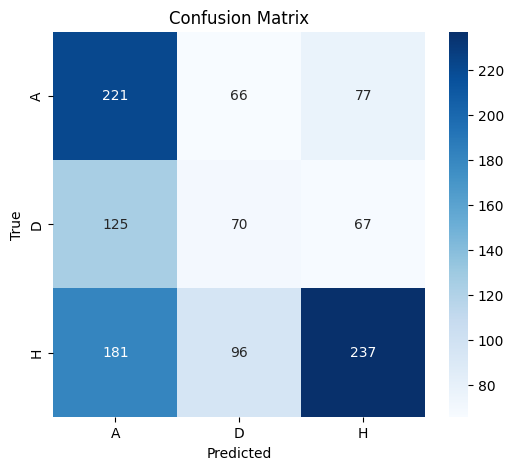

In [16]:
from sklearn.linear_model import LogisticRegression

# Train the model
model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced', multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

# Predict & Evaluate
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {acc:.3f}\n")

print("🏷️ Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Show Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Random Forest Classifier


✅ Accuracy: 0.515

🏷️ Classification Report:
              precision    recall  f1-score   support

           A       0.49      0.49      0.49       364
           D       0.26      0.05      0.09       262
           H       0.55      0.77      0.64       514

    accuracy                           0.51      1140
   macro avg       0.43      0.44      0.41      1140
weighted avg       0.46      0.51      0.46      1140



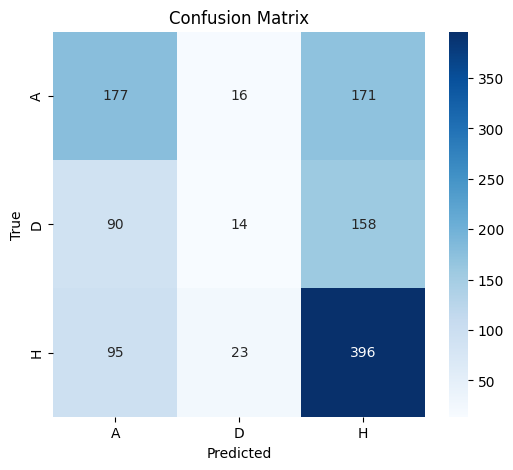

In [10]:
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Predict & Evaluate
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {acc:.3f}\n")

print("🏷️ Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Show Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# XG Boost

In [ ]:
# !pip install xgboost

In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:20:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Accuracy: 0.530

🏷️ Classification Report:
              precision    recall  f1-score   support

           A       0.49      0.55      0.52       364
           D       0.46      0.02      0.04       262
           H       0.55      0.77      0.64       514

    accuracy                           0.53      1140
   macro avg       0.50      0.45      0.40      1140
weighted avg       0.51      0.53      0.47      1140



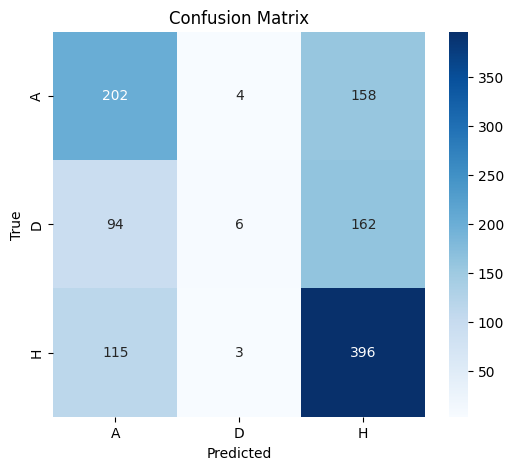

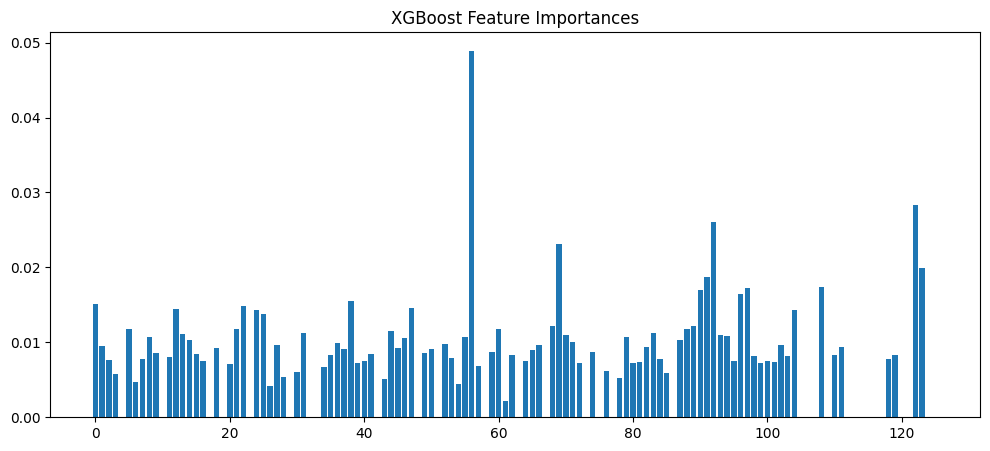

In [13]:
# Train the model
model = XGBClassifier(
    n_estimators=150,
    learning_rate=0.02,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=3
)
model.fit(X_train, y_train)

# Predict & Evaluate
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {acc:.3f}\n")

print("🏷️ Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Show Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Show Importance of
importances = model.feature_importances_
plt.figure(figsize=(12, 5))
plt.bar(range(len(importances)), importances)
plt.title("XGBoost Feature Importances")
plt.show()

# CNN

In [14]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ---------------------------
# Prep: reshape tabular features for 1D CNN
# ---------------------------
def to_1d_cnn_shape(X):
    X = np.asarray(X, dtype=np.float32)
    if X.ndim != 2:
        raise ValueError(f"Expected X with shape (N, F). Got {X.shape}")
    # reshape to (N, F, 1)
    return X[..., np.newaxis]

X_train_cnn = to_1d_cnn_shape(X_train)
X_test_cnn  = to_1d_cnn_shape(X_test)
num_features = X_train_cnn.shape[1]

# Labels: support 1D ints or one-hot
y_train_arr = np.asarray(y_train)
y_test_arr  = np.asarray(y_test)

if y_train_arr.ndim == 1:
    num_classes = int(y_train_arr.max()) + 1
    loss_fn = "sparse_categorical_crossentropy"
    y_true_eval = y_test_arr
else:
    num_classes = y_train_arr.shape[1]
    loss_fn = "categorical_crossentropy"
    y_true_eval = np.argmax(y_test_arr, axis=1)

# ---------------------------
# Class weights (balanced), similar to scikit
# ---------------------------
class_weight = None
sample_weight = None
if y_train_arr.ndim == 1:
    classes = np.unique(y_train_arr)
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_arr)
    class_weight = dict(zip(classes, weights))
else:
    # one-hot -> build per-sample weights
    classes = np.arange(num_classes)
    y_int = np.argmax(y_train_arr, axis=1)
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_int)
    w_map = dict(zip(classes, weights))
    sample_weight = np.vectorize(w_map.get)(y_int).astype(np.float32)

# ---------------------------
# Model: simple 1D CNN for tabular data
# ---------------------------
def build_tabular_cnn(n_features, n_classes):
    k = 3 if n_features >= 3 else (2 if n_features == 2 else 1)
    model = keras.Sequential([
        layers.Input(shape=(n_features, 1)),

        layers.Conv1D(32, kernel_size=k, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv1D(32, kernel_size=k, padding="same", activation="relu"),
        layers.Dropout(0.15),

        layers.Conv1D(64, kernel_size=k, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.35),
        layers.Dense(n_classes, activation="softmax"),
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=loss_fn, metrics=["accuracy"])
    return model

In [15]:
model = build_tabular_cnn(num_features, num_classes)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 126, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 126, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 126, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 126, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,531 (72.39 KB)

 Trainable params: 18,339 (71.64 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)]

history = model.fit(
    X_train_cnn, y_train_arr,
    validation_split=0.15,
    epochs=150,
    batch_size=64,
    class_weight=class_weight,         # used if labels are integer
    sample_weight=sample_weight,       # used if labels are one-hot
    callbacks=callbacks,
    verbose=1
)

Epoch 1/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.3525 - loss: 1.0894 - val_accuracy: 0.2271 - val_loss: 1.1177
Epoch 2/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3982 - loss: 1.0711 - val_accuracy: 0.2271 - val_loss: 1.1413
Epoch 3/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4177 - loss: 1.0614 - val_accuracy: 0.2401 - val_loss: 1.1313
Epoch 4/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4368 - loss: 1.0564 - val_accuracy: 0.4164 - val_loss: 1.0985
Epoch 5/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4389 - loss: 1.0502 - val_accuracy: 0.3897 - val_loss: 1.0865
Epoch 6/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4205 - loss: 1.0503 - val_accuracy: 0.3998 - val_loss: 1.0652
Epoch 7/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4420 - loss: 1.0394 - val_accuracy: 0.3481 - val_loss: 1.0883
Epoch 8/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4398 - loss: 1.0482 - val_accuracy: 0.4349 

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

✅ Accuracy: 0.514

🏷️ Classification Report:
              precision    recall  f1-score   support

           A       0.48      0.46      0.47       364
           D       0.35      0.03      0.06       262
           H       0.53      0.79      0.64       514

    accuracy                           0.51      1140
   macro avg       0.45      0.43      0.39      1140
weighted avg       0.47      0.51      0.45      1140



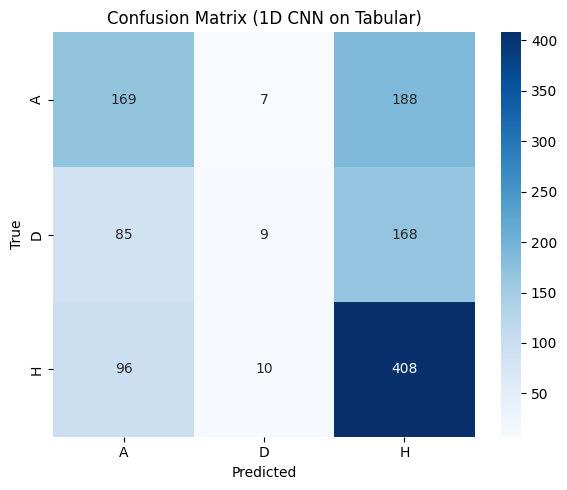

In [ ]:
# ---------------------------
# Predict & Evaluate
# ---------------------------
proba = model.predict(X_test_cnn)
y_pred = np.argmax(proba, axis=1)

acc = accuracy_score(y_true_eval, y_pred)
print(f"\n✅ Accuracy: {acc:.3f}\n")

print("🏷️ Classification Report:")
target_names = getattr(label_encoder, "classes_", None)
print(classification_report(y_true_eval, y_pred, target_names=target_names))

# ---------------------------
# Confusion Matrix
# ---------------------------
cm = confusion_matrix(y_true_eval, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names if target_names is not None else np.arange(num_classes),
            yticklabels=target_names if target_names is not None else np.arange(num_classes))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (1D CNN on Tabular)")
plt.tight_layout()
plt.show()

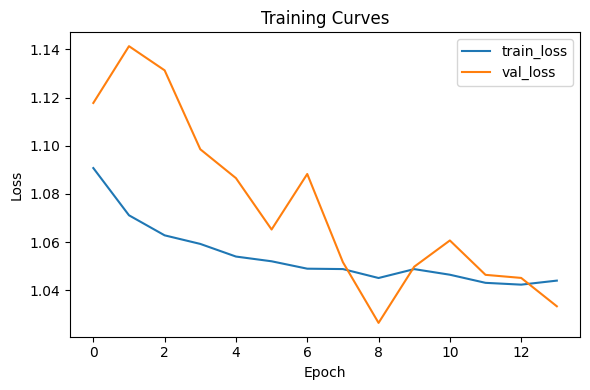

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curves")
plt.legend()
plt.tight_layout()
plt.show()

# Choosing Hyper-Parameters

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Base model
xgb = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    num_class=3,
    use_label_encoder=False,
    random_state=42
)

# Parameter distributions
param_dist = {
    "n_estimators": randint(100, 2000),
    "learning_rate": uniform(0.01, 0.3),
    "max_depth": randint(3, 10),
    "min_child_weight": randint(1, 10),
    "gamma": uniform(0, 5),
    "subsample": uniform(0.5, 0.5),       # 0.5–1.0
    "colsample_bytree": uniform(0.5, 0.5),# 0.5–1.0
    "reg_alpha": uniform(0, 1),
    "reg_lambda": uniform(0.5, 2)
}

# Random search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,                # Increase for more thorough search
    scoring='accuracy',       # Or 'balanced_accuracy'
    cv=5,                      # StratifiedKFold by default
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit search
random_search.fit(X_train, y_train)

# Results
print("Best score:", random_search.best_score_)
print("Best parameters:", random_search.best_params_)

# Evaluate on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:28:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best score: 0.517174515235457
Best parameters: {'colsample_bytree': np.float64(0.6594878151468806), 'gamma': np.float64(4.2243765548472725), 'learning_rate': np.float64(0.01698158072074776), 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 716, 'reg_alpha': np.float64(0.4960374542934062), 'reg_lambda': np.float64(1.8857807173838788), 'subsample': np.float64(0.6741683022265987)}
Test accuracy: 0.5385964912280702


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:07:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Accuracy: 0.539

🏷️ Classification Report:
              precision    recall  f1-score   support

           A       0.50      0.57      0.54       364
           D       0.00      0.00      0.00       262
           H       0.56      0.79      0.65       514

    accuracy                           0.54      1140
   macro avg       0.35      0.45      0.40      1140
weighted avg       0.41      0.54      0.47      1140



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


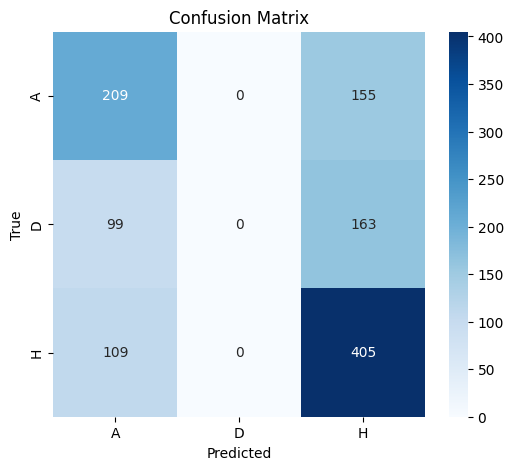

In [18]:
# Train the model with the new best parameters as found.
model = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    num_class=3,
    use_label_encoder=False,
    random_state=42,
    colsample_bytree=0.6594878151468806,
    gamma=4.2243765548472725,
    learning_rate=0.01698158072074776,
    max_depth=4,
    min_child_weight=3,
    n_estimators=716,
    reg_alpha=0.4960374542934062,
    reg_lambda=1.8857807173838788,
    subsample=0.6741683022265987
)
model.fit(X_train, y_train)

# Predict & Evaluate
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {acc:.3f}\n")

print("🏷️ Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Show Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Predict more draws

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# -----------------------------
# Inputs assumed to exist:
#   X_train, X_test  -> pandas DataFrames with named columns (from previous step)
#   y_train, y_test  -> encoded integer labels (LabelEncoder)
#   label_encoder    -> fitted LabelEncoder (classes_ contains e.g. ['A','D','H'] or similar)
# -----------------------------

# 1) Make a chronological validation split FROM THE TRAIN PERIOD (last 20% by index order)
def chrono_split(X, y, val_frac=0.2):
    # Keep the order: first part -> train_sub, last part -> val_sub
    n = len(X)
    cut = int(np.floor((1 - val_frac) * n))
    X_tr, X_val = X.iloc[:cut], X.iloc[cut:]
    y_tr, y_val = y[:cut], y[cut:]
    return X_tr, X_val, y_tr, y_val

X_tr, X_val, y_tr, y_val = chrono_split(X_train, y_train, val_frac=0.2)

# 2) Helper: build sample weights with "balanced" base + extra boost for the Draw class
#    We'll grid-search the boost factor in [1.0 ... 3.0]
classes = np.unique(y_tr)
class_to_idx = {c:i for i,c in enumerate(classes)}

# infer which index is "Draw" in your encoded labels
# Works if your original label_encoder.classes_ contains something like ['A','D','H'] or ['Away','Draw','Home']
# Adjust this mapping if your class names differ.
if hasattr(label_encoder, "classes_"):
    # find the encoded integer for the string that looks like Draw
    draw_candidates = [i for i, name in enumerate(label_encoder.classes_) if str(name).lower().startswith("d")]
    if len(draw_candidates) == 1:
        DRAW_ID = draw_candidates[0]
    else:
        # fallback: assume the middle class is draw (3-way classification)
        DRAW_ID = 1
else:
    DRAW_ID = 1

def make_sample_weight(y, draw_boost=1.0):
    base_cw = compute_class_weight(class_weight="balanced", classes=classes, y=y)
    base_cw = base_cw.astype(float)

    # Multiply the Draw weight
    # Map from global class id to local 'classes' order
    cw_map = {cls: w for cls, w in zip(classes, base_cw)}
    # bump only the draw class
    if DRAW_ID in cw_map:
        cw_map[DRAW_ID] *= draw_boost

    w = np.array([cw_map[yi] for yi in y])
    return w

# 3) Train a model with early stopping on the validation slice
def fit_xgb(Xtr, ytr, Xval, yval, sample_weight_tr=None, sample_weight_val=None, random_state=42):
    model = XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        num_class=len(np.unique(y_train)),
        tree_method="hist",
        learning_rate=0.05,
        n_estimators=2000,          # rely on early stopping
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state
    )
    model.fit(
        Xtr, ytr,
        sample_weight=sample_weight_tr,
        eval_set=[(Xval, yval)],
        sample_weight_eval_set=[sample_weight_val] if sample_weight_val is not None else None,
        # early_stopping_rounds=100,
        verbose=False
    )
    return model

# 4) Bias adjustment: add a constant to the DRAW logit, then softmax
def softmax(z, axis=1):
    z = np.asarray(z)
    zmax = np.max(z, axis=axis, keepdims=True)
    ez = np.exp(z - zmax)
    return ez / ez.sum(axis=axis, keepdims=True)

def apply_draw_bias(model, X, bias):
    # raw margins (logits) shape [n_samples, n_classes]
    logits = model.predict(X, output_margin=True)
    logits = np.array(logits)
    logits[:, DRAW_ID] += bias
    probs_adj = softmax(logits, axis=1)
    y_pred_adj = probs_adj.argmax(axis=1)
    return y_pred_adj, probs_adj

# 5) Grid search on (draw_boost, draw_bias) using macro-F1 on the validation set
draw_boost_grid = [1.0, 1.5, 2.0, 2.5, 3.0]
draw_bias_grid  = np.arange(-1.0, 2.01, 0.25)  # logit bias to add to the draw class

best = {"f1": -1, "boost": None, "bias": None, "model": None}

for boost in draw_boost_grid:
    sw_tr  = make_sample_weight(y_tr, draw_boost=boost)
    sw_val = make_sample_weight(y_val, draw_boost=boost)  # keep early stopping aligned with weighting
    model  = fit_xgb(X_tr, y_tr, X_val, y_val, sample_weight_tr=sw_tr, sample_weight_val=sw_val)

    # Search the bias
    for bias in draw_bias_grid:
        y_pred_val, _ = apply_draw_bias(model, X_val, bias)
        f1 = f1_score(y_val, y_pred_val, average="macro")
        if f1 > best["f1"]:
            best.update({"f1": f1, "boost": boost, "bias": bias, "model": model})

print(f"Best on validation -> macro-F1={best['f1']:.4f}, draw_boost={best['boost']}, draw_bias={best['bias']}")

# 6) (Optional but recommended) Retrain on TRAIN+VAL with the chosen draw_boost,
#     using a tiny internal early-stopping split to avoid leaking test info.
def retrain_on_trainval(X_train_full, y_train_full, draw_boost, random_state=42):
    # internal split (chronological): last 10% for early stopping
    n = len(X_train_full)
    cut = int(np.floor(0.9 * n))
    Xtr, Xes = X_train_full.iloc[:cut], X_train_full.iloc[cut:]
    ytr, yes = y_train_full[:cut], y_train_full[cut:]
    sw_tr  = make_sample_weight(ytr, draw_boost)
    sw_es  = make_sample_weight(yes, draw_boost)

    model = fit_xgb(Xtr, ytr, Xes, yes, sample_weight_tr=sw_tr, sample_weight_val=sw_es, random_state=random_state)
    return model

X_train_full = pd.concat([X_tr, X_val], axis=0)
y_train_full = np.concatenate([y_tr, y_val])
final_model = retrain_on_trainval(X_train_full, y_train_full, best["boost"], random_state=42)

# 7) Evaluate on TEST with the tuned draw bias
y_pred_test, test_probs = apply_draw_bias(final_model, X_test, best["bias"])
acc = accuracy_score(y_test, y_pred_test)
macro_f1 = f1_score(y_test, y_pred_test, average="macro")
print("\n=== TEST METRICS (with draw weight + bias) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Macro-F1:  {macro_f1:.4f}")
print("\nPer-class report:")
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

# 8) (Optional) Inspect how often we predict Draw now
pred_counts = pd.Series(y_pred_test).value_counts().reindex(range(len(label_encoder.classes_)), fill_value=0)
print("\nPredicted class counts on TEST:")
print(pd.Series(pred_counts.values, index=label_encoder.classes_))

Best on validation -> macro-F1=0.4308, draw_boost=3.0, draw_bias=-0.25

=== TEST METRICS (with draw weight + bias) ===
Accuracy:  0.4833
Macro-F1:  0.4276

Per-class report:
              precision    recall  f1-score   support

           A       0.47      0.47      0.47       364
           D       0.28      0.18      0.22       262
           H       0.55      0.65      0.59       514

    accuracy                           0.48      1140
   macro avg       0.43      0.43      0.43      1140
weighted avg       0.46      0.48      0.47      1140


Predicted class counts on TEST:
A    365
D    169
H    606
dtype: int64
